# Compute non-stationarities in behavior across a 30 minute sessions

1. Get variables
1. Standardize variables
1. Cluster
1. Print to toml

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import savefig, setup_plotting_env
from rl_analysis.io.df import dlight_exclude
from sklearn import cluster

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
dlight_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
use_tup = "(0.0, 0.3)"

In [7]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

## Load in pre-processed data

In [11]:
feature_df = pd.read_parquet(features_save_file)
use_area = "dls"
feature_df = feature_df.loc[feature_df["area"] == use_area].copy()
feature_df = dlight_exclude(feature_df, exclude_target=False, syllable_key="syllable")
feature_df = feature_df.loc[~feature_df["session_number"].isin([1, 2, 3, 4])].copy()
feature_df = feature_df.loc[feature_df["window_tup"] == use_tup].copy()

## Quickly look at a some features...

In [12]:
# zscore everything quickly
zfeature_df = feature_df.copy()
bins = pd.cut(
    feature_df["timestamp"], np.arange(0, 1830, lagged_cfg["clustering"]["bin_size"])
)
bins = bins.apply(lambda x: x.right)

In [13]:
numeric_columns = zfeature_df.select_dtypes("number").columns
zfeature_df[numeric_columns] = zfeature_df.groupby("uuid")[numeric_columns].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [14]:
numeric_data = zfeature_df.groupby(bins)[numeric_columns].mean()
numeric_data = numeric_data.apply(lambda x: x.rolling(3, 1, True).mean())

In [16]:
cluster_data = numeric_data[lagged_cfg["clustering"]["use_features"]]
clf = cluster.KMeans(
    n_clusters=lagged_cfg["clustering"]["nclusters"], random_state=100
)  # PIN random state
clusters = clf.fit_predict(cluster_data)

bound_clusters = clusters.copy()
bound_clusters[0] = -10
bound_clusters = np.insert(bound_clusters, len(clusters), -10)
boundaries = np.flatnonzero(np.diff(bound_clusters) != 0)

/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
session_bins = numeric_data.index[boundaries]
session_bins = session_bins.tolist()

In [18]:
boundary_pts = []
for _bin in session_bins:
    boundary_pts.append(
        numeric_data[lagged_cfg["clustering"]["use_features"]].index.get_loc(_bin) + 0.5
    )

In [19]:
boundary_pts[0] = 0

In [20]:
aliases = {
    "velocity_2d_mm": "velocity",
    "jerk_2d_mm": "jerk",
    "acceleration_2d_mm": "acceleration",
    "velocity_angle": "angle velocity",
    "velocity_height": "z velocity",
    "signal_reref_dff_z_max": "dLight peak",
}

In [21]:
use_aliases = {
    k: v
    for k, v in aliases.items()
    if k in lagged_cfg["clustering"]["display_features"]
}

In [22]:
setup_plotting_env()

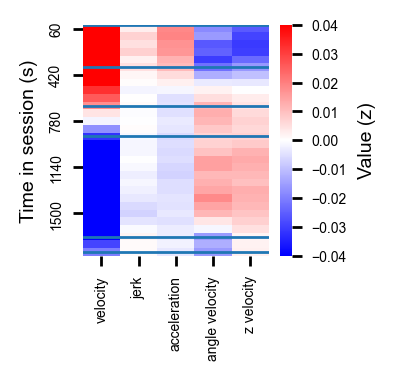

In [23]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5))
h = sns.heatmap(
    numeric_data[lagged_cfg["clustering"]["display_features"]][use_aliases.keys()],
    vmin=-0.04,
    vmax=0.04,
    cmap="bwr",
    cbar_kws={"label": "Value (z)"},
    yticklabels=6,
)

for _pt in boundary_pts:
    ax.axhline(y=_pt)

ax.set_xticklabels([aliases[_.get_text()] for _ in ax.get_xticklabels()])
ax.set_ylabel("Time in session (s)")
savefig(
    fig, os.path.join(figure_cfg["store_dir"], "session_clusters"), bbox_inches="tight"
)

In [24]:
use_session_bins = session_bins
use_session_bins[0] = 0

In [25]:
dct = {"session_bins": use_session_bins}

In [26]:
with open(
    os.path.join(proc_dirs["dlight"], "lagged_analysis_session_bins.toml"), "w"
) as f:
    toml.dump(dct, f)

In [27]:
use_session_bins

[0, 360, 660, 900, 1680, 1800]